In [58]:
%pip install -e git+https://github.com/cldf-datasets/wals.git@v2020#egg=cldfbench_wals --quiet

  DEPRECATION: Legacy editable install of cldfbench_wals from git+https://github.com/cldf-datasets/wals.git@v2020#egg=cldfbench_wals (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
Note: you may need to restart the kernel to use updated packages.


In [59]:
from cldfbench import get_dataset
import pandas as pd
import numpy as np
from IPython.display import display
from conlanger.utils import display_rows

In [60]:
wals = get_dataset("wals").cldf_reader()

In [61]:
lang_df = pd.DataFrame(wals.iter_rows("LanguageTable"))[["ID", "Name", "ISO639P3code"]]
display(lang_df.head(3))
lang_df.shape

,ID,Name,ISO639P3code
0,aab,Arapesh (Abu),None
1,aar,Aari,aiw
2,aba,Abau,aau


(2662, 3)

In [62]:
# param_df = (
#     pd.DataFrame(wals.iter_rows("ParameterTable"))
#     .set_index(["Area", "Chapter"])
#     .drop(columns=["Description", "Contributor_ID"])
# )

# param_df = param_df[
#     ~param_df.index.get_level_values("Area").isin(["Sign Languages", "Other"])
# ]

# areas = param_df.index.unique(level="Area")
# chapters = param_df.index.unique(level="Chapter")

# print(f"Areas: {areas.shape[0]}")
# print(f"Chapters: {chapters.shape[0]}")
# print(f"Parameters: {param_df.shape[0]}")

# parameters = param_df[["ID", "Name"]].to_numpy()

# params_by_area = [param_df[param_df.index.get_level_values("Area") == area]["ID"].to_numpy() for area in areas]
# max_size = max([len(a) for a in params_by_area])
# params_by_area = np.array([np.hstack([a, np.full(max_size - a.size, "")]) for a in params_by_area])

# params_by_area.shape, parameters.shape

In [63]:
param_df = (
    pd.DataFrame(wals.iter_rows("ParameterTable"))
    .drop(columns=["Description", "Contributor_ID"])
)

word_order_negation = ["Position of Negative Morpheme With Respect to Subject, Object, and Verb", "Order of Negative Morpheme and Verb"]

param_df.loc[param_df["Chapter"].isin(word_order_negation), "Area"] = "Word Order - Negation"
# param_df.loc[param_df["Area"] == "Phonology", "Area"] = "Phonology & Morphology"
# param_df.loc[param_df["Area"] == "Morphology", "Area"] = "Phonology & Morphology"
# param_df.loc[param_df["Area"] == "Nominal Syntax", "Area"] = "Nominal Syntax & Verbal Categories"
# param_df.loc[param_df["Area"] == "Verbal Categories", "Area"] = "Nominal Syntax & Verbal Categories"
# param_df.loc[param_df["Area"] == "Complex Sentences", "Area"] = "Complex Sentences & Lexicon"
# param_df.loc[param_df["Area"] == "Lexicon", "Area"] = "Complex Sentences & Lexicon"

param_df = param_df[
    ~param_df["Area"].isin(["Sign Languages", "Other"])
]

for area, df in param_df.set_index(["Area", "Chapter"]).groupby(level=0):
    display(df)

param_counts_by_area = param_df[["Area", "ID"]].groupby("Area", sort=False).agg(param_count=('ID', 'count'), params=('ID', list)).reset_index()
max_params_by_area = param_counts_by_area["param_count"].max()
display(param_counts_by_area)

param_counts_by_chapter = (param_df[["Area", "Chapter", "ID"]]
                           .groupby(["Area", "Chapter"], sort=False)
                           .agg(param_count=('ID', 'count'))
                           .reset_index()
)

params_by_chapter = (param_counts_by_chapter
                           .groupby("Area", sort=False)
                           .agg(total=('param_count', 'sum'), max=('param_count', 'max'), unique_count_per_chapter=('param_count', (lambda x: list(x.unique()))))
                           .reset_index()
)
display(params_by_chapter)


max_params_by_chapter = param_counts_by_chapter["param_count"].max()

all_parameters = np.array([l + [''] * (max_params_by_area - len(l)) for l in param_counts_by_area["params"].to_list()])


areas = param_df.Area.unique()
chapters = param_df.Chapter.unique()

print(f"Areas: {areas.shape[0]}")
print(f"Chapters: {chapters.shape[0]}")
print(f"Parameters: {param_df.shape[0]}")

parameters = param_df[["ID", "Name"]].to_numpy()

param_counts_by_area = [len(param_df[param_df["Area"] == area]["ID"]) for area in areas]
max_size = max(param_counts_by_area)

params_by_area = [param_df[param_df["Area"] == area]["ID"].to_numpy() for area in areas]
params_by_area = np.array([np.hstack([a, np.full(max_size - a.size, "")]) for a in params_by_area])

params_by_area.shape, parameters.shape

ID  \
Area              Chapter                              
Complex Sentences Relativization on Subjects    122A   
                  Relativization on Obliques    123A   
                  'Want' Complement Subjects    124A   
                  Purpose Clauses               125A   
                  'When' Clauses                126A   
                  Reason Clauses                127A   
                  Utterance Complement Clauses  128A   

                                                                        Name  
Area              Chapter                                                     
Complex Sentences Relativization on Subjects      Relativization on Subjects  
                  Relativization on Obliques      Relativization on Obliques  
                  'Want' Complement Subjects      'Want' Complement Subjects  
                  Purpose Clauses                            Purpose Clauses  
                  'When' Clauses                              'When' Clauses  
                  Reason Clauses                              Reason Clauses  
                  Utterance Complement Clauses  Utterance Complement Clauses

ID  \
Area    Chapter                                               
Lexicon Hand and Arm                                   129A   
        Finger and Hand                                130A   
        Finger and Hand                                130B   
        Numeral Bases                                  131A   
        Number of Non-Derived Basic Colour Categories  132A   
        Number of Basic Colour Categories              133A   
        Green and Blue                                 134A   
        Red and Yellow                                 135A   
        M-T Pronouns                                   136A   
        M-T Pronouns                                   136B   
        N-M Pronouns                                   137A   
        N-M Pronouns                                   137B   
        Tea                                            138A   

                                                                                                    Name  
Area    Chapter                                                                                           
Lexicon Hand and Arm                                                                        Hand and Arm  
        Finger and Hand                                                                  Finger and Hand  
        Finger and Hand                                Cultural Categories of Languages with Identity...  
        Numeral Bases                                                                      Numeral Bases  
        Number of Non-Derived Basic Colour Categories      Number of Non-Derived Basic Colour Categories  
        Number of Basic Colour Categories                              Number of Basic Colour Categories  
        Green and Blue                                                                    Green and Blue  
        Red and Yellow                                                                    Red and Yellow  
        M-T Pronouns                                                                        M-T Pronouns  
        M-T Pronouns                                                          M in First Person Singular  
        N-M Pronouns                                                                        N-M Pronouns  
        N-M Pronouns                                                         M in Second Person Singular  
        Tea                                                                                          Tea

ID  \
Area       Chapter                                                   
Morphology Fusion of Selected Inflectional Formatives          20A   
           Exponence of Selected Inflectional Formatives       21A   
           Exponence of Selected Inflectional Formatives       21B   
           Inflectional Synthesis of the Verb                  22A   
           Locus of Marking in the Clause                      23A   
           Locus of Marking in Possessive Noun Phrases         24A   
           Locus of Marking: Whole-language Typology           25A   
           Locus of Marking: Whole-language Typology           25B   
           Prefixing vs. Suffixing in Inflectional Morphology  26A   
           Reduplication                                       27A   
           Case Syncretism                                     28A   
           Syncretism in Verbal Person/Number Marking          29A   

                                                                                                            Name  
Area       Chapter                                                                                                
Morphology Fusion of Selected Inflectional Formatives                 Fusion of Selected Inflectional Formatives  
           Exponence of Selected Inflectional Formatives           Exponence of Selected Inflectional Formatives  
           Exponence of Selected Inflectional Formatives               Exponence of Tense-Aspect-Mood Inflection  
           Inflectional Synthesis of the Verb                                 Inflectional Synthesis of the Verb  
           Locus of Marking in the Clause                                         Locus of Marking in the Clause  
           Locus of Marking in Possessive Noun Phrases               Locus of Marking in Possessive Noun Phrases  
           Locus of Marking: Whole-language Typology                   Locus of Marking: Whole-language Typology  
           Locus of Marking: Whole-language Typology                           Zero Marking of A and P Arguments  
           Prefixing vs. Suffixing in Inflectional Morphology  Prefixing vs. Suffixing in Inflectional Morpho...  
           Reduplication                                                                           Reduplication  
           Case Syncretism                                                                       Case Syncretism  
           Syncretism in Verbal Person/Number Marking                 Syncretism in Verbal Person/Number Marking

ID  \
Area               Chapter                                                   
Nominal Categories Number of Genders                                   30A   
                   Sex-based and Non-sex-based Gender Systems          31A   
                   Systems of Gender Assignment                        32A   
                   Coding of Nominal Plurality                         33A   
                   Occurrence of Nominal Plurality                     34A   
                   Plurality in Independent Personal Pronouns          35A   
                   The Associative Plural                              36A   
                   Definite Articles                                   37A   
                   Indefinite Articles                                 38A   
                   Inclusive/Exclusive Distinction in Independent ...  39A   
                   Inclusive/Exclusive Distinction in Independent ...  39B   
                   Inclusive/Exclusive Distinction in Verbal Infle...  40A   
                   Distance Contrasts in Demonstratives                41A   
                   Pronominal and Adnominal Demonstratives             42A   
                   Third Person Pronouns and Demonstratives            43A   
                   Gender Distinctions in Independent Personal Pro...  44A   
                   Politeness Distinctions in Pronouns                 45A   
                   Indefinite Pronouns                                 46A   
                   Intensifiers and Reflexive Pronouns                 47A   
                   Person Marking on Adpositions                       48A   
                   Number of Cases                                     49A   
                   Asymmetrical Case-Marking                           50A   
                   Position of Case Affixes                            51A   
                   Comitatives and Instrumentals                       52A   
                   Ordinal Numerals                                    53A   
                   Distributive Numerals                               54A   
                   Numeral Classifiers                                 55A   
                   Conjunctions and Universal Quantifiers              56A   
                   Position of Pronominal Possessive Affixes           57A   

                                                                                                                    Name  
Area               Chapter                                                                                                
Nominal Categories Number of Genders                                                                   Number of Genders  
                   Sex-based and Non-sex-based Gender Systems                 Sex-based and Non-sex-based Gender Systems  
                   Systems of Gender Assignment                                             Systems of Gender Assignment  
                   Coding of Nominal Plurality                                               Coding of Nominal Plurality  
                   Occurrence of Nominal Plurality                                       Occurrence of Nominal Plurality  
                   Plurality in Independent Personal Pronouns                 Plurality in Independent Personal Pronouns  
                   The Associative Plural                                                         The Associative Plural  
                   Definite Articles                                                                   Definite Articles  
                   Indefinite Articles                                                               Indefinite Articles  
                   Inclusive/Exclusive Distinction in Independent ...  Inclusive/Exclusive Distinction in Independent...  
                   Inclusive/Exclusive Distinction in Independent ...          Inclusive/Exclusive Forms in Pama-Nyungan  
                   Inclusive/Exclusive Distinction in 

ID  \
Area           Chapter                                           
Nominal Syntax Obligatory Possessive Inflection            58A   
               Obligatory Possessive Inflection            58B   
               Possessive Classification                   59A   
               Genitives, Adjectives and Relative Clauses  60A   
               Adjectives without Nouns                    61A   
               Action Nominal Constructions                62A   
               Noun Phrase Conjunction                     63A   
               Nominal and Verbal Conjunction              64A   

                                                                                                 Name  
Area           Chapter                                                                                 
Nominal Syntax Obligatory Possessive Inflection                      Obligatory Possessive Inflection  
               Obligatory Possessive Inflection                            Number of Possessive Nouns  
               Possessive Classification                                    Possessive Classification  
               Genitives, Adjectives and Relative Clauses  Genitives, Adjectives and Relative Clauses  
               Adjectives without Nouns                                      Adjectives without Nouns  
               Action Nominal Constructions                              Action Nominal Constructions  
               Noun Phrase Conjunction                                        Noun Phrase Conjunction  
               Nominal and Verbal Conjunction                          Nominal and Verbal Conjunction

ID  \
Area      Chapter                                                  
Phonology Consonant Inventories                               1A   
          Vowel Quality Inventories                           2A   
          Consonant-Vowel Ratio                               3A   
          Voicing in Plosives and Fricatives                  4A   
          Voicing and Gaps in Plosive Systems                 5A   
          Uvular Consonants                                   6A   
          Glottalized Consonants                              7A   
          Lateral Consonants                                  8A   
          The Velar Nasal                                     9A   
          Vowel Nasalization                                 10A   
          Vowel Nasalization                                 10B   
          Front Rounded Vowels                               11A   
          Syllable Structure                                 12A   
          Tone                                               13A   
          Fixed Stress Locations                             14A   
          Weight-Sensitive Stress                            15A   
          Weight Factors in Weight-Sensitive Stress Systems  16A   
          Rhythm Types                                       17A   
          Absence of Common Consonants                       18A   
          Presence of Uncommon Consonants                    19A   

                                                                                                          Name  
Area      Chapter                                                                                               
Phonology Consonant Inventories                                                          Consonant Inventories  
          Vowel Quality Inventories                                                  Vowel Quality Inventories  
          Consonant-Vowel Ratio                                                          Consonant-Vowel Ratio  
          Voicing in Plosives and Fricatives                                Voicing in Plosives and Fricatives  
          Voicing and Gaps in Plosive Systems                              Voicing and Gaps in Plosive Systems  
          Uvular Consonants                                                                  Uvular Consonants  
          Glottalized Consonants                                                        Glottalized Consonants  
          Lateral Consonants                                                                Lateral Consonants  
          The Velar Nasal                                                                      The Velar Nasal  
          Vowel Nasalization                                                                Vowel Nasalization  
          Vowel Nasalization                                                       Nasal Vowels in West Africa  
          Front Rounded Vowels                                                            Front Rounded Vowels  
          Syllable Structure                                                                Syllable Structure  
          Tone                                                                                            Tone  
          Fixed Stress Locations                                                        Fixed Stress Locations  
          Weight-Sensitive Stress                                                      Weight-Sensitive Stress  
          Weight Factors in Weight-Sensitive Stress Systems  Weight Factors in Weight-Sensitive Stress Systems  
          Rhythm Types                                                                            Rhythm Types  
          Absence of Common Consonants                                            Absence of Common Consonants  
          Presence of Uncommon Consonants                                      Presence of Uncommon Consonants

ID  \
Area           Chapter                                                    
Simple Clauses Alignment of Case Marking of Full Noun Phrases       98A   
               Alignment of Case Marking of Pronouns                99A   
               Alignment of Verbal Person Marking                  100A   
               Expression of Pronominal Subjects                   101A   
               Verbal Person Marking                               102A   
               Third Person Zero of Verbal Person Marking          103A   
               Order of Person Markers on the Verb                 104A   
               Ditransitive Constructions: The Verb 'Give'         105A   
               Reciprocal Constructions                            106A   
               Passive Constructions                               107A   
               Antipassive Constructions                           108A   
               Antipassive Constructions                           108B   
               Applicative Constructions                           109A   
               Applicative Constructions                           109B   
               Periphrastic Causative Constructions                110A   
               Nonperiphrastic Causative Constructions             111A   
               Negative Morphemes                                  112A   
               Symmetric and Asymmetric Standard Negation          113A   
               Subtypes of Asymmetric Standard Negation            114A   
               Negative Indefinite Pronouns and Predicate Nega...  115A   
               Polar Questions                                     116A   
               Predicative Possession                              117A   
               Predicative Adjectives                              118A   
               Nominal and Locational Predication                  119A   
               Zero Copula for Predicate Nominals                  120A   
               Comparative Constructions                           121A   

                                                                                                                Name  
Area           Chapter                                                                                                
Simple Clauses Alignment of Case Marking of Full Noun Phrases         Alignment of Case Marking of Full Noun Phrases  
               Alignment of Case Marking of Pronouns                           Alignment of Case Marking of Pronouns  
               Alignment of Verbal Person Marking                                 Alignment of Verbal Person Marking  
               Expression of Pronominal Subjects                                   Expression of Pronominal Subjects  
               Verbal Person Marking                                                           Verbal Person Marking  
               Third Person Zero of Verbal Person Marking                 Third Person Zero of Verbal Person Marking  
               Order of Person Markers on the Verb                               Order of Person Markers on the Verb  
               Ditransitive Constructions: The Verb 'Give'               Ditransitive Constructions: The Verb 'Give'  
               Reciprocal Constructions                                                     Reciprocal Constructions  
               Passive Constructions                                                           Passive Constructions  
               Antipassive Constructions                                                   Antipassive Constructions  
               Antipassive Constructions                                Productivity of the Antipassive Construction  
               Applicative Constructions                                                   Applicative Constructions  
               Applicative Constructions                                              Other Roles of Applied Objects  
               Periphrastic Causative Constructions             

ID  \
Area              Chapter                                                   
Verbal Categories Perfective/Imperfective Aspect                      65A   
                  The Past Tense                                      66A   
                  The Future Tense                                    67A   
                  The Perfect                                         68A   
                  Position of Tense-Aspect Affixes                    69A   
                  The Morphological Imperative                        70A   
                  The Prohibitive                                     71A   
                  Imperative-Hortative Systems                        72A   
                  The Optative                                        73A   
                  Situational Possibility                             74A   
                  Epistemic Possibility                               75A   
                  Overlap between Situational and Epistemic Modal...  76A   
                  Semantic Distinctions of Evidentiality              77A   
                  Coding of Evidentiality                             78A   
                  Suppletion According to Tense and Aspect            79A   
                  Suppletion According to Tense and Aspect            79B   
                  Verbal Number and Suppletion                        80A   

                                                                                                                   Name  
Area              Chapter                                                                                                
Verbal Categories Perfective/Imperfective Aspect                                         Perfective/Imperfective Aspect  
                  The Past Tense                                                                         The Past Tense  
                  The Future Tense                                                                     The Future Tense  
                  The Perfect                                                                               The Perfect  
                  Position of Tense-Aspect Affixes                                     Position of Tense-Aspect Affixes  
                  The Morphological Imperative                                             The Morphological Imperative  
                  The Prohibitive                                                                       The Prohibitive  
                  Imperative-Hortative Systems                                             Imperative-Hortative Systems  
                  The Optative                                                                             The Optative  
                  Situational Possibility                                                       Situational Possibility  
                  Epistemic Possibility                                                           Epistemic Possibility  
                  Overlap between Situational and Epistemic Modal...  Overlap between Situational and Epistemic Moda...  
                  Semantic Distinctions of Evidentiality                         Semantic Distinctions of Evidentiality  
                  Coding of Evidentiality                                                       Coding of Evidentiality  
                  Suppletion According to Tense and Aspect                     Suppletion According to Tense and Aspect  
                  Suppletion According to Tense and Aspect                     Suppletion in Imperatives and Hortatives  
                  Verbal Number and Suppletion                                             Verbal Number and Suppletion

ID  \
Area       Chapter                                                   
Word Order Order of Subject, Object and Verb                   81A   
           Order of Subject, Object and Verb                   81B   
           Order of Subject and Verb                           82A   
           Order of Object and Verb                            83A   
           Order of Object, Oblique, and Verb                  84A   
           Order of Adposition and Noun Phrase                 85A   
           Order of Genitive and Noun                          86A   
           Order of Adjective and Noun                         87A   
           Order of Demonstrative and Noun                     88A   
           Order of Numeral and Noun                           89A   
           Order of Relative Clause and Noun                   90A   
           Order of Relative Clause and Noun                   90B   
           Order of Relative Clause and Noun                   90C   
           Order of Relative Clause and Noun                   90D   
           Order of Relative Clause and Noun                   90E   
           Order of Relative Clause and Noun                   90F   
           Order of Relative Clause and Noun                   90G   
           Order of Degree Word and Adjective                  91A   
           Position of Polar Question Particles                92A   
           Position of Interrogative Phrases in Content Qu...  93A   
           Order of Adverbial Subordinator and Clause          94A   
           Relationship between the Order of Object and Ve...  95A   
           Relationship between the Order of Object and Ve...  96A   
           Relationship between the Order of Object and Ve...  97A   

                                                                                                            Name  
Area       Chapter                                                                                                
Word Order Order of Subject, Object and Verb                                   Order of Subject, Object and Verb  
           Order of Subject, Object and Verb                   Languages with two Dominant Orders of Subject,...  
           Order of Subject and Verb                                                   Order of Subject and Verb  
           Order of Object and Verb                                                     Order of Object and Verb  
           Order of Object, Oblique, and Verb                                 Order of Object, Oblique, and Verb  
           Order of Adposition and Noun Phrase                               Order of Adposition and Noun Phrase  
           Order of Genitive and Noun                                                 Order of Genitive and Noun  
           Order of Adjective and Noun                                               Order of Adjective and Noun  
           Order of Demonstrative and Noun                                       Order of Demonstrative and Noun  
           Order of Numeral and Noun                                                   Order of Numeral and Noun  
           Order of Relative Clause and Noun                                   Order of Relative Clause and Noun  
           Order of Relative Clause and Noun                                         Prenominal relative clauses  
           Order of Relative Clause and Noun                                        Postnominal relative clauses  
           Order of Relative Clause and Noun                                  Internally-headed relative clauses  
           Order of Relative Clause and Noun                                        Correlative relative clauses  
           Order of Relative Clause and Noun                                           Adjoined relative clauses  
           Order of Relative Clause and Noun                                      Double-headed relative clauses  
           Order of Degree Word and Adjective             

ID  \
Area                  Chapter                                                    
Word Order - Negation Order of Negative Morpheme and Verb                 143A   
                      Order of Negative Morpheme and Verb                 143B   
                      Order of Negative Morpheme and Verb                 143C   
                      Order of Negative Morpheme and Verb                 143D   
                      Order of Negative Morpheme and Verb                 143E   
                      Order of Negative Morpheme and Verb                 143F   
                      Order of Negative Morpheme and Verb                 143G   
                      Position of Negative Morpheme With Respect to S...  144A   
                      Position of Negative Morpheme With Respect to S...  144B   
                      Position of Negative Morpheme With Respect to S...  144C   
                      Position of Negative Morpheme With Respect to S...  144D   
                      Position of Negative Morpheme With Respect to S...  144E   
                      Position of Negative Morpheme With Respect to S...  144F   
                      Position of Negative Morpheme With Respect to S...  144G   
                      Position of Negative Morpheme With Respect to S...  144H   
                      Position of Negative Morpheme With Respect to S...  144I   
                      Position of Negative Morpheme With Respect to S...  144J   
                      Position of Negative Morpheme With Respect to S...  144K   
                      Position of Negative Morpheme With Respect to S...  144L   
                      Position of Negative Morpheme With Respect to S...  144M   
                      Position of Negative Morpheme With Respect to S...  144N   
                      Position of Negative Morpheme With Respect to S...  144O   
                      Position of Negative Morpheme With Respect to S...  144P   
                      Position of Negative Morpheme With Respect to S...  144Q   
                      Position of Negative Morpheme With Respect to S...  144R   
                      Position of Negative Morpheme With Respect to S...  144S   
                      Position of Negative Morpheme With Respect to S...  144T   
                      Position of Negative Morpheme With Respect to S...  144U   
                      Position of Negative Morpheme With Respect to S...  144V   
                      Position of Negative Morpheme With Respect to S...  144W   
                      Position of Negative Morpheme With Respect to S...  144X   
                      Position of Negative Morpheme With Respect to S...  144Y   

                                                                                                                       Name  
Area                  Chapter                                                                                                
Word Order - Negation Order of Negative Morpheme and Verb                               Order of Negative Morpheme and Verb  
                      Order of Negative Morpheme and Verb                                        Obligatory Double Negation  
                      Order of Negative Morpheme and Verb                                          Optional Double Negation  
                      Order of Negative Morpheme and Verb                                          Optional Triple Negation  
                      Order of Negative Morpheme and Verb                                      Preverbal Negative Morphemes  
                      Order of Negative Morpheme and Verb                                     Postverbal Negative Morphemes  
                      Order of Negative Morpheme and Verb                   Minor morphological means of signaling negation  
                      Position of Negative Morpheme With Respect to S...  Position of Negative Word With Respect to Subj...  
                      Posit

,Area,param_count,params
0,Phonology,20,"[1A, 2A, 3A, 4A, 5A, 6A, 7A, 8A, 9A, 10A, 10B,..."
1,Morphology,12,"[20A, 21A, 21B, 22A, 23A, 24A, 25A, 25B, 26A, ..."
2,Nominal Categories,29,"[30A, 31A, 32A, 33A, 34A, 35A, 36A, 37A, 38A, ..."
3,Nominal Syntax,8,"[58A, 58B, 59A, 60A, 61A, 62A, 63A, 64A]"
4,Verbal Categories,17,"[65A, 66A, 67A, 68A, 69A, 70A, 71A, 72A, 73A, ..."
5,Word Order,24,"[81A, 81B, 82A, 83A, 84A, 85A, 86A, 87A, 88A, ..."
6,Simple Clauses,26,"[98A, 99A, 100A, 101A, 102A, 103A, 104A, 105A,..."
7,Complex Sentences,7,"[122A, 123A, 124A, 125A, 126A, 127A, 128A]"
8,Lexicon,13,"[129A, 130A, 130B, 131A, 132A, 133A, 134A, 135..."
9,Word Order - Negation,32,"[143A, 143B, 143C, 143D, 143E, 143F, 143G, 144..."


,Area,total,max,unique_count_per_chapter
0,Phonology,20,2,"[1, 2]"
1,Morphology,12,2,"[1, 2]"
2,Nominal Categories,29,2,"[1, 2]"
3,Nominal Syntax,8,2,"[2, 1]"
4,Verbal Categories,17,2,"[1, 2]"
5,Word Order,24,7,"[2, 1, 7]"
6,Simple Clauses,26,2,"[1, 2]"
7,Complex Sentences,7,1,[1]
8,Lexicon,13,2,"[1, 2]"
9,Word Order - Negation,32,25,"[7, 25]"


Areas: 10
Chapters: 140
Parameters: 188


((10, 32), (188, 2))

In [64]:
code_df = pd.DataFrame(wals.iter_rows("CodeTable"))
code_df.head(3)

,ID,Parameter_ID,Name,Description,Number,icon
0,1A-1,1A,Small,Small,1,c0000dd
1,1A-2,1A,Moderately small,Moderately small,2,c9999ff
2,1A-3,1A,Average,Average,3,cffffff


In [65]:
value_df = (
    pd.DataFrame(wals.iter_rows("ValueTable"))
    .drop(columns=["ID", "Code_ID", "Comment", "Source", "Example_ID"])
    .merge(
        lang_df[["ID", "Name"]].rename(columns={"Name": "Language_Name"}),
        left_on="Language_ID",
        right_on="ID",
    )
)
value_df["Value"] = value_df["Value"].astype(int)
value_df["Language_Name"] = value_df["Language_Name"].str.split(" (", regex=False).str[0]

parameter_value_counts = value_df.Parameter_ID.value_counts()
high_parameter_value_counts = parameter_value_counts[parameter_value_counts > 750]

print(value_df.shape)
value_df = value_df[value_df.Parameter_ID.isin(high_parameter_value_counts.index)]
print(value_df.shape)
value_df.head(3)

(76475, 5)
(30217, 5)


,Language_ID,Parameter_ID,Value,ID,Language_Name
0,aab,81A,2,aab,Arapesh
1,aab,82A,1,aab,Arapesh
2,aab,83A,2,aab,Arapesh


In [66]:
example_df = pd.DataFrame(wals.iter_rows("ExampleTable"))
example_df.head(3)

,ID,Language_ID,Primary_Text,Analyzed_Word,Gloss,Translated_Text,Meta_Language_ID,Comment
0,igt-1,mnd,tāmen tōu zìxíngchē,"[tāmen, tōu, zìxíngchē]","[3PL, steal, bicycle]",They steal bicycles.,None,None
1,igt-2,mnd,[wǒ gěi nǐ de] shū,"[[wǒ, gěi, nǐ, de], shū]","[[1SG, give, 2SG, LINK], book]",the book [that I gave you],None,None
2,igt-3,nbd,dımın ıdw ṍww(ı),"[dımın, ıdw, ṍww(ı)]","[ten, eight, two]",82,None,None


In [67]:
def map_params(df):
    lang = df.to_numpy()
    lang_value_indices = np.isin(lang[:, 0], params_by_area).nonzero()

    param_indices = np.isin(params_by_area, lang[:, 0]).nonzero()

    result = np.zeros(params_by_area.shape)
    result[param_indices] = lang[:, 1][lang_value_indices]

    return result


values_by_language = value_df.groupby(["Language_ID", "Language_Name"])
unique_languages = np.array([[id, name] for (id, name), group in values_by_language])

language_parameters = np.stack(
            values_by_language.apply(map_params, include_groups=False).to_numpy()
        ).astype(int)

# remove languages with parameter values missing from some Areas
missing_areas_mask = language_parameters.sum(axis=2).astype(bool).sum(axis=1) > 4

selected_unique_languages = unique_languages[missing_areas_mask]
selected_language_parameters = np.array([np.hstack([arr[i][:n] for i, n in enumerate(param_counts_by_area)]) for arr in language_parameters[missing_areas_mask][:]])

language_parameters.shape, selected_language_parameters.shape, unique_languages.shape, selected_unique_languages.shape, parameters.shape

((1657, 10, 32), (1021, 188), (1657, 2), (1021, 2), (188, 2))

In [68]:
np.savez_compressed(
    "./data/language_parameters.npz",
    language_parameters=selected_language_parameters,
    languages=selected_unique_languages,
    parameters=parameters,
)

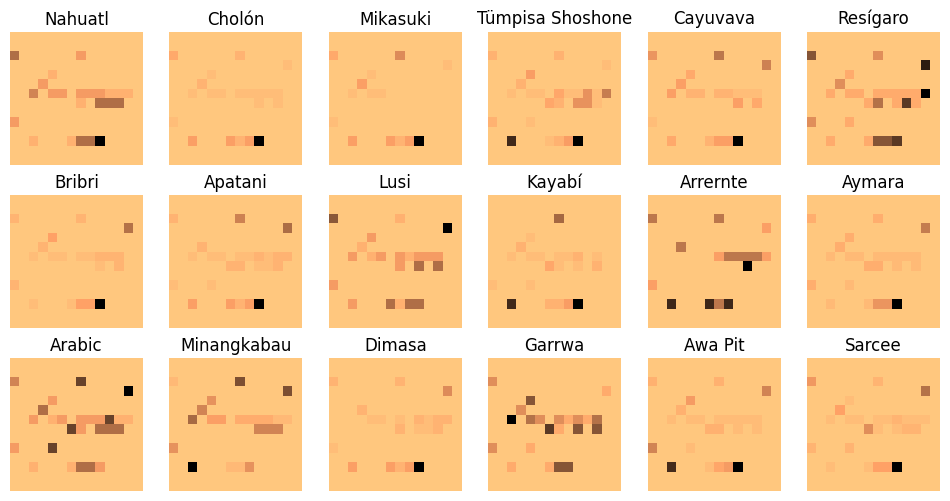

In [69]:
import matplotlib.pyplot as plt

r, c = 3, 6

gen = np.random.default_rng()
sample_indices = gen.choice(selected_unique_languages.shape[0], r * c, replace=False)
samples = selected_language_parameters[sample_indices]
sample_names = selected_unique_languages[:, 1][sample_indices]

sample_images = np.hstack([
    samples, 
    np.zeros((samples.shape[0], 8))
    ]).reshape(samples.shape[0], 14, 14)

display_rows(sample_images, titles=sample_names, cmap="copper_r", r=r, c=c, size=(12, 6))